In [1]:
from lib.utilities import *
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
datadir = "./tsm_targets/01-17-22" # All files in this directory + subdirectories are loaded
datadir = "./tsm_targets" # All files in this directory + subdirectories are loaded
#datadir = "C:/Turbo-SM/SMDATA/Untitled"
#datadir = "C:/Turbo-SM/SMDATA/John/01-17-22"
selected_filename = "Untitled006" # focus for subsequent analysis
#selected_filename = "OMP25-Cerulean3-cell4003"
file_type = '.tsm'
horizontal_cropping = [250, 750]  # This is the cropping recommended for 1024-px width
#horizontal_cropping = [125, 375]  # This is the cropping recommended for 512-px width
t_cropping = [0, -1]  # TSM artifacts
binning = 3

In [3]:
# Load data
processed = [] # to avoid re-processing later
data_loader = DataLoader()
if file_type == '.tsm':
    data_loader.load_all_tsm(data_dir=datadir, file_only=selected_filename)
    
print(data_loader.get_n_files_loaded(), "files loaded.")

Untitled004.tbn
Untitled004.tsm
Untitled005.tbn
Untitled005.tsm
Untitled006.tbn
Untitled006.tsm
./tsm_targets/Untitled006.tsm to be treated as TSM file to open
Reading file as 200 images of size 1024 x 320
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 1024, 'raw_height': 320, 'interval_between_samples': 1.0, 'number_of_trials': 1}
1 files loaded.


In [4]:
# Select data of interest        
selected_data = data_loader.select_data_by_keyword(selected_filename)

# If PhotoZ cannot manage the image size, increase binning and cropping
selected_data.clip_data(y_range=horizontal_cropping, t_range=t_cropping)
selected_data.bin_data(binning=binning)

raw_data, meta, rli = selected_data.get_data(), selected_data.get_meta(), selected_data.get_rli()
fp_data = selected_data.fp_data

{'points_per_trace': 199, 'raw_width': 199, 'raw_height': 100, 'interval_between_samples': 1.0, 'number_of_trials': 1} (1, 199, 319, 500)


(1, 199, 107, 167)


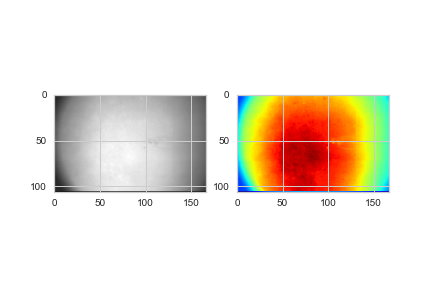

In [5]:
# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='gray')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()

rli_high_cp = np.copy(raw_data[0,0,:,:]).astype(np.uint16)

In [6]:
# Fill in missing metadata
meta['version'] = 5
meta['slice_number'] = 5
meta['location_number'] = 5
meta['record_number'] = 5
meta['camera_program'] = 2

meta['interval_between_trials'] = 1
meta['acquisition_gain'] = 1
meta['time_RecControl'] = 5

meta['reset_onset'] = 1
meta['reset_duration'] = 5
meta['shutter_onset'] = 5
meta['shutter_duration'] = 5

meta['stimulation1_onset'] = 20
meta['stimulation1_duration'] = 1
meta['stimulation2_onset'] = 0
meta['stimulation2_duration'] = 0

meta['acquisition_onset'] = 1
meta['interval_between_samples'] = 5

meta['raw_width'] = raw_data.shape[2]
meta['raw_height'] = raw_data.shape[3]
meta['points_per_trace'] = raw_data.shape[1]
meta['number_of_trials'] = raw_data.shape[0]
num_fp_pts = 4
num_diodes = int(meta['raw_width'] * meta['raw_height'] + num_fp_pts)
rli = {}
rli['rli_low'] = np.zeros((num_diodes), dtype = np.uint16)
rli['rli_high'] = np.zeros((num_diodes), dtype = np.uint16) 
rli['rli_high'][:meta['raw_width'] * meta['raw_height']] = np.transpose(rli_high_cp).reshape(-1)
rli['rli_max'] = np.ones((num_diodes), dtype = np.uint16)

print(num_diodes, [rli[r].shape for r in rli])

17873 [(17873,), (17873,), (17873,)]


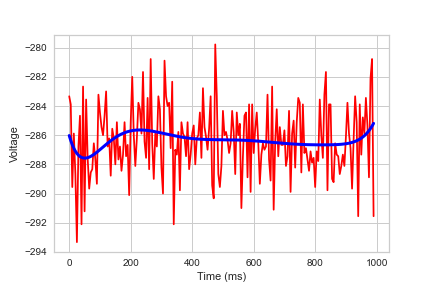

In [7]:
# Run this cell at most once

# Apply baseline correction here. Because PhotoZ chokes on baseline correcting TurboSM data
tr = Tracer()
#data inversing
raw_data = -raw_data

# Need to subtract off the low-frequency voltage drift. First-order correction
tr.correct_background(meta, raw_data)

(1, 199, 107, 167) [[[[2226 1741 2349 ... 2050 2231 1967]
   [1935 1924 1995 ... 2310 2037 2145]
   [2096 2037 2067 ... 2118 1716 1897]
   ...
   [2035 1938 1936 ... 1941 1996 1972]
   [1989 1819 2180 ... 2229 1974 1889]
   [2038 2100 2080 ... 2003 2033 2046]]

  [[2207 2060 1908 ... 2057 1683 1855]
   [1993 1927 2197 ... 1642 1723 1982]
   [2121 1926 1729 ... 2011 2149 1990]
   ...
   [2093 1992 1801 ... 1866 2114 2248]
   [2183 2134 1933 ... 1893 1946 2120]
   [1977 1931 1944 ... 1872 1913 1871]]

  [[1742 2176 1665 ... 2119 2004 1804]
   [2103 2009 1727 ... 1753 1958 1609]
   [1788 1902 1892 ... 1691 1982 1897]
   ...
   [1874 1707 2062 ... 1982 1920 1795]
   [1798 1866 1823 ... 1515 1762 1869]
   [1829 1971 1993 ... 1985 1956 1977]]

  ...

  [[2290 1743 2592 ... 2162 2217 2332]
   [1903 1717 2206 ... 2164 2037 1757]
   [2012 2088 2035 ... 2402 2380 1947]
   ...
   [2345 2105 2506 ... 2008 2299 2021]
   [1847 2054 1760 ... 1890 1911 1918]
   [2150 2036 2126 ... 1791 1938 1947]]

  

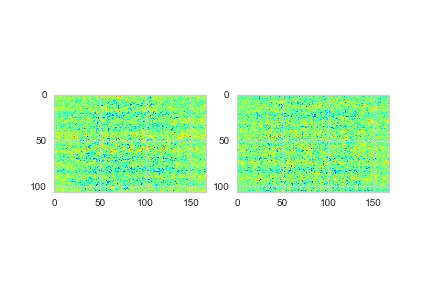

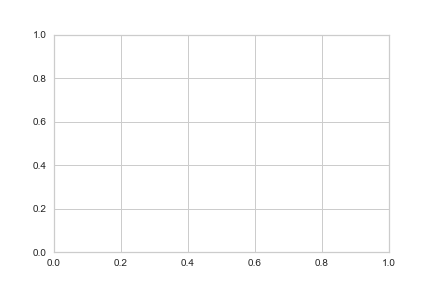

In [8]:
plt.subplots() # finalize plot from previous cell
# normalize raw data to 12-bit range
def normalize_bit_range(raw_data, bits=12):
    raw_data = raw_data.astype(np.float64)
    raw_data -= np.min(raw_data)
    raw_data /= np.max(raw_data)
    raw_data *= (2 ** bits)

    return raw_data.astype(np.uint16)

fp_data = normalize_bit_range(fp_data)
raw_data = normalize_bit_range(raw_data)
print(raw_data.shape, raw_data)

# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()


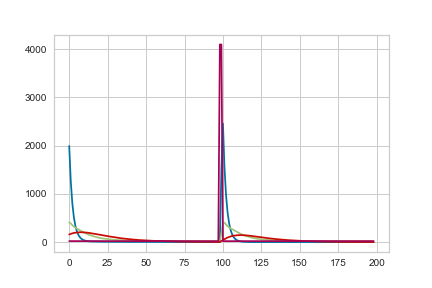

In [9]:
fig, ax = plt.subplots()
ax.plot(fp_data[t_cropping[0]:t_cropping[1], :])

[[[[2226 1741 2349 ... 2050 2231 1967]
   [1935 1924 1995 ... 2310 2037 2145]
   [2096 2037 2067 ... 2118 1716 1897]
   ...
   [2035 1938 1936 ... 1941 1996 1972]
   [1989 1819 2180 ... 2229 1974 1889]
   [2038 2100 2080 ... 2003 2033 2046]]

  [[2207 2060 1908 ... 2057 1683 1855]
   [1993 1927 2197 ... 1642 1723 1982]
   [2121 1926 1729 ... 2011 2149 1990]
   ...
   [2093 1992 1801 ... 1866 2114 2248]
   [2183 2134 1933 ... 1893 1946 2120]
   [1977 1931 1944 ... 1872 1913 1871]]

  [[1742 2176 1665 ... 2119 2004 1804]
   [2103 2009 1727 ... 1753 1958 1609]
   [1788 1902 1892 ... 1691 1982 1897]
   ...
   [1874 1707 2062 ... 1982 1920 1795]
   [1798 1866 1823 ... 1515 1762 1869]
   [1829 1971 1993 ... 1985 1956 1977]]

  ...

  [[2290 1743 2592 ... 2162 2217 2332]
   [1903 1717 2206 ... 2164 2037 1757]
   [2012 2088 2035 ... 2402 2380 1947]
   ...
   [2345 2105 2506 ... 2008 2299 2021]
   [1847 2054 1760 ... 1890 1911 1918]
   [2150 2036 2126 ... 1791 1938 1947]]

  [[2391 1918 1897 ..

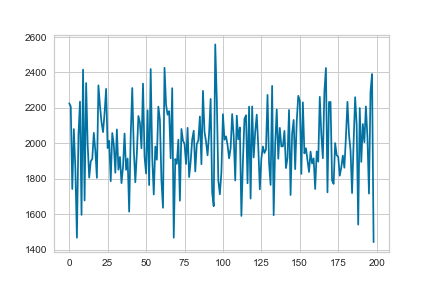

In [10]:
# Write data
print(raw_data, raw_data.shape)
zda_writer = ZDA_Writer()
zda_writer.write_zda_to_file(raw_data, meta, selected_filename + ".zda", rli, fp_data[t_cropping[0]:t_cropping[1], :])

plt.subplots()
plt.plot(raw_data[0,:,0,0])